In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import vmap, value_and_grad, grad, jit, random
import jax.nn as jnn
import math
import optax
import scipy
from mpl_toolkits.mplot3d import Axes3D

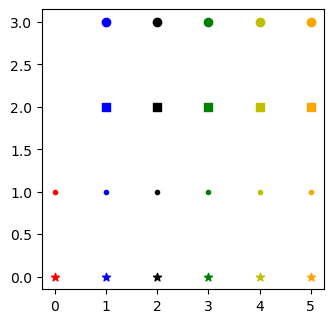

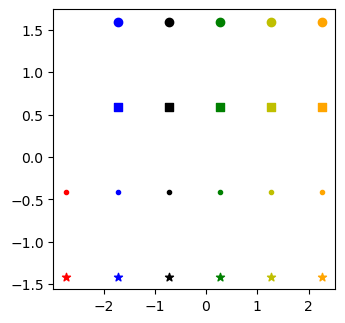

In [2]:
plot_rows = 2
plot_cols = 2
colour_full_list = ['r','b','k','g','y','orange']
marker_full_list = ['*','.','s','o','>','<']

points = np.zeros([2, 100])
points_raw = np.zeros([2, 100])
markers = []
colours = []
not_allowed = [(0,3),(0,2)]
D = 0
for x in range(6):
    for y in range(4):
        if not((x,y) in not_allowed):
            colours.append(colour_full_list[x])
            markers.append(marker_full_list[y])
            points_raw[:,D] = np.array([x,y])
            #y = y + 1*x
            points[:,D] = np.array([x, y])
            D += 1
points_raw = points_raw[:,:D]
points = points[:,:D]
points = points + np.abs(np.min(points, axis = 1))[:,None]

plt.figure(figsize = (8,8))
plt.subplot(plot_rows,plot_cols,1)
for count in range(D):
    plt.scatter(points[0,count], points[1,count], c = colours[count], marker = markers[count])

plt.figure(figsize = (8,8))
points_demean = points - np.mean(points, axis = 1)[:,None]
plt.subplot(plot_rows,plot_cols,1)
for count in range(D):
    plt.scatter(points_demean[0,count], points_demean[1,count], c = colours[count], marker = markers[count])

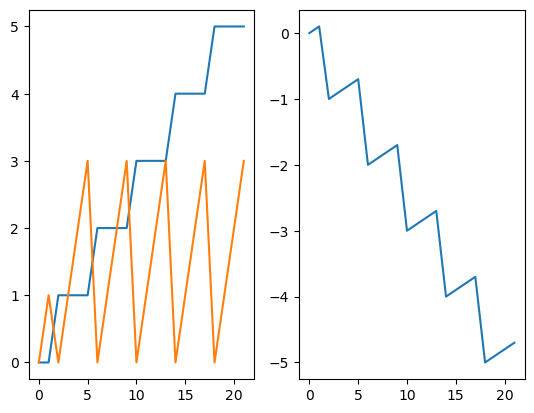

In [3]:
plt.subplot(1,2,1)
plt.plot(points[0,:])
plt.plot(points[1,:])

plt.subplot(1,2,2)
plt.plot(-points[0,:] +0.1*points[1,:])

0.05 0.00124921972503933
0.1 0.00498756211208895
0.3 0.04403065089105507
0.5 0.1180339887498949
1 0.41421356237309515


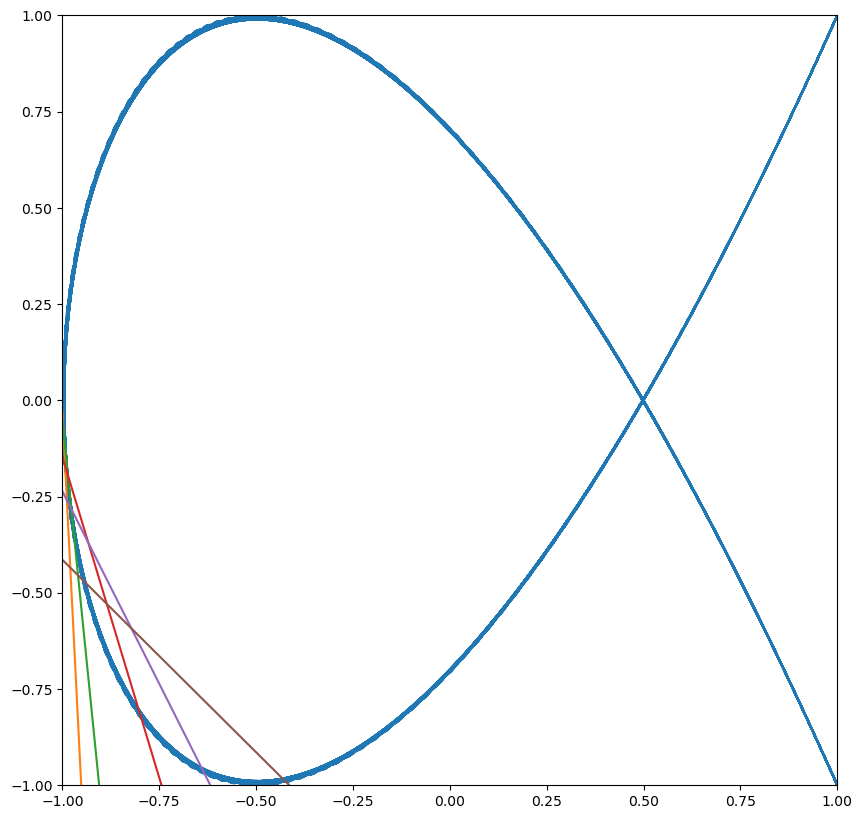

In [4]:
angles = np.arange(0, 100, 0.1)
cos_1 = np.cos(2*angles)
cos_2 = np.cos(3*angles)
plt.figure(figsize = (10,10))
plt.plot(cos_1, cos_2)
plt.xlim([-1,1])
plt.ylim([-1,1])
b_x = 1
b_y = 1
covar = 0
vs = [0.05, 0.1, 0.3, 0.5, 1]
x_plot = np.linspace(-1, 1, 100)

for v_chosen in vs:
    Delta_plot = -b_x + np.sqrt(b_x**2 + (v_chosen**2*b_y**2 + v_chosen*covar))
    #Delta_plot = -b_x+np.sqrt(b_x**2 + v_chosen**2*b_y**2)
    print(v_chosen, Delta_plot)
    y_plot = -1/v_chosen *x_plot  -b_x/v_chosen - Delta_plot/v_chosen
    
    plt.plot(x_plot, y_plot)
    

In [5]:
y_plot

array([-0.41421356, -0.43441558, -0.4546176 , -0.47481962, -0.49502164,
       -0.51522366, -0.53542568, -0.5556277 , -0.57582972, -0.59603174,
       -0.61623376, -0.63643578, -0.6566378 , -0.67683982, -0.69704185,
       -0.71724387, -0.73744589, -0.75764791, -0.77784993, -0.79805195,
       -0.81825397, -0.83845599, -0.85865801, -0.87886003, -0.89906205,
       -0.91926407, -0.93946609, -0.95966811, -0.97987013, -1.00007215,
       -1.02027417, -1.04047619, -1.06067821, -1.08088023, -1.10108225,
       -1.12128427, -1.14148629, -1.16168831, -1.18189033, -1.20209235,
       -1.22229437, -1.24249639, -1.26269841, -1.28290043, -1.30310245,
       -1.32330447, -1.34350649, -1.36370851, -1.38391053, -1.40411255,
       -1.42431457, -1.44451659, -1.46471861, -1.48492063, -1.50512265,
       -1.52532467, -1.54552669, -1.56572871, -1.58593073, -1.60613275,
       -1.62633477, -1.64653679, -1.66673881, -1.68694084, -1.70714286,
       -1.72734488, -1.7475469 , -1.76774892, -1.78795094, -1.80

In [6]:
H = 5
I = np.random.normal(0,1, [H,3])
points_bias = np.vstack([points, np.ones([1,points.shape[1]])])

@jit
def generate_rep(I, inputs):
    g = jnn.relu(I@inputs)
    #g = I@inputs
    g_bias = jnp.vstack([g, jnp.ones(g.shape[1])[None,:]])
    return g_bias

@jit
def loss_weight_I(I):
    return jnp.sum(jnp.power(I[:,:-1],2))

@jit
def generate_R(g, outputs):
    mat0 = jnp.matmul(g, g.T)
    mat1 = jnp.matmul(g, outputs.T)
    mat2 = jnp.matmul(jnp.linalg.inv(mat0 + 0.01*jnp.eye(H+1)), mat1)
    return mat2

@jit
def loss_fit(g, R, outputs):
    preds = R.T@g
    return jnp.linalg.norm(outputs - preds) 

@jit
def loss_R(R):
    R_sub = R[:-1,:]
    return jnp.sum(jnp.power(R_sub, 2))

@jit
def loss_act(g):
    return jnp.sum(jnp.power(g[:-1,:], 2))

mu_fit = 100000
mu_G = 1
mu_R = 1
mu_I = 1
fit_thresh = 0.01

@jit
def loss(params, inputs, outputs):
    g = generate_rep(params["I"], inputs)
    R = generate_R(g, points)

    return mu_fit*jnn.relu(loss_fit(g, R, outputs)-fit_thresh) + mu_G*loss_act(g) + mu_I*loss_weight_I(params["I"]) + mu_R*loss_weight_I(R)
    
@jit
def update(params, inputs, outputs, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, inputs, outputs)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, value

random_seed = 43321213
learning_rate = 1e-4

re_init = 1
if re_init:
    key = random.PRNGKey(random_seed)
    I = random.normal(key, (H, 3))*0.001
    I = I.at[:,-1].set(2)
    optimizer = optax.adam(learning_rate)
    # Obtain the `opt_state` that contains statistics for the optimizer.
    params = {'I': I}
    opt_state = optimizer.init(params)
print(loss(params, points_bias, points))
min_loss = np.infty

I0000 00:00:1714496770.728611       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


904327.06


In [7]:
# Optimisation, run and re-run until it stops hitting new records
T = 10000000
print_iter = 10000

for t in range(T):
    params, opt_state, loss = update(params, points_bias, points, opt_state)

    if t % print_iter == 0:
        g = generate_rep(params["I"], points_bias)
        R = generate_R(g, points)

        L_f = loss_fit(g, R, points)
        L_a = loss_act(g)
        L_R = loss_weight_I(R)
        L_I = loss_weight_I(params["I"])    
        print(f"Step {t}, Loss: {loss:.5f}, Fit: {L_f:.5f}, Act: {L_a:.5f}, R: {L_R:.5f}, I: {L_I:.5f}")
        #print(f"Step {t}, Loss: {loss:.5f}")#, Fit: {L_f:.5f}, Act: {L_a:.5f}, Wei: {L_w:.5f}, R: {L_R:.5f}, Pos: {L_p:.5f}, PI: {L_PI:.5f}")

        min_this_step = 0

    if loss < min_loss:
        params_best = params
        min_loss = loss
        if min_this_step == 0:
            print(f'New min! {loss}')
            min_this_step = 1

Step 0, Loss: 904327.06250, Fit: 9.02019, Act: 439.71042, R: 61.58550, I: 0.00001
New min! 904327.0625
Step 10000, Loss: 1361.53003, Fit: 0.01802, Act: 442.29916, R: 9.97841, I: 0.25296
New min! 1006.9593505859375
Step 20000, Loss: 235.64583, Fit: 0.00820, Act: 229.18811, R: 5.65161, I: 0.76050
New min! 235.6458282470703
Step 30000, Loss: 159.02641, Fit: 0.00790, Act: 151.20728, R: 6.98614, I: 0.83814
New min! 158.68798828125
Step 40000, Loss: 138.63434, Fit: 0.00875, Act: 130.59979, R: 7.22620, I: 0.79643
New min! 138.24649047851562
Step 50000, Loss: 125.43865, Fit: 0.00888, Act: 117.27921, R: 7.38645, I: 0.76294
New min! 124.49959564208984


KeyboardInterrupt: 

In [120]:
print(min_loss)

63.38515


-2.727272727272727


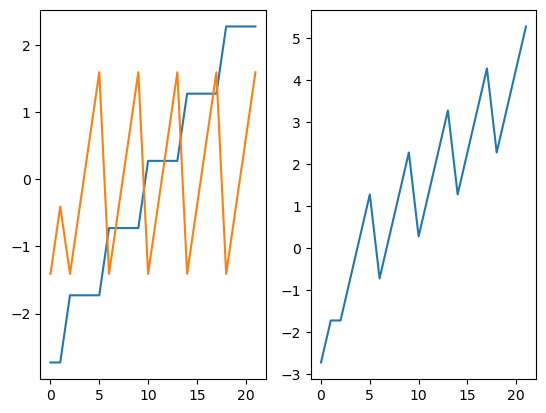

In [121]:
points_demean = points - np.mean(points, axis = 1)[:,None]
points_shift = points_demean[0,:]+1*points[1,:]
print(np.min(points_shift))
plt.subplot(1,2,1)
plt.plot(points_demean.T)
plt.subplot(1,2,2)
plt.plot(points_shift)

63.38515
Propotion of Activity Kept: 1.0


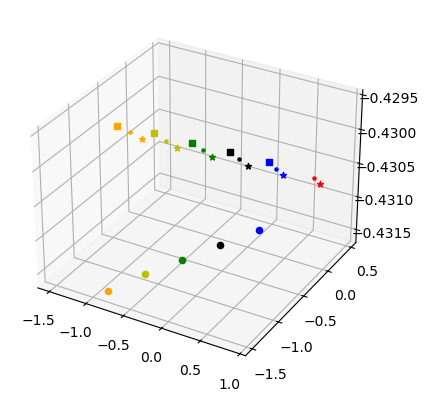

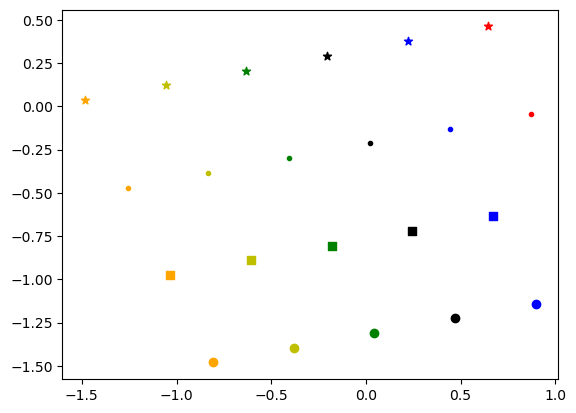

In [122]:
def get_2_PCs(vecs, num_eigs = 2):
    vecs = vecs - np.mean(vecs, axis = 1)[:,None]
    covar = vecs@vecs.T
    eigvals, eigvecs = np.linalg.eig(covar)
    
    ordering = np.argsort(eigvals)[::-1]
    print(f"Propotion of Activity Kept: {np.sum(eigvals[ordering[:num_eigs]])/np.sum(eigvals)}")
    return np.real(eigvecs[:,ordering[:num_eigs]])
g_best = generate_rep(params_best['I'], points_bias)
print(min_loss)
PCs = get_2_PCs(g_best, num_eigs = 3)
proj_best = PCs.T@g_best

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for count in range(D):
    ax.scatter(proj_best[0,count], proj_best[1,count], proj_best[2,count], c = colours[count], marker = markers[count])

fig = plt.figure()
for count in range(D):
    plt.scatter(proj_best[0,count], proj_best[1,count], c = colours[count], marker = markers[count])

In [123]:
np.linalg.norm(R, axis = 0)

array([2.6271515, 1.8680196], dtype=float32)

In [124]:
points_raw[1,:] == 

SyntaxError: invalid syntax (3262651086.py, line 1)

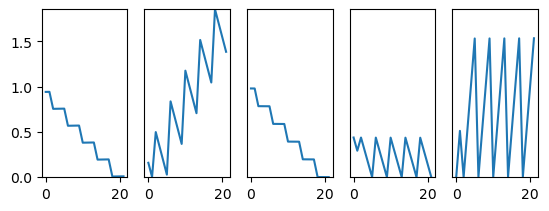

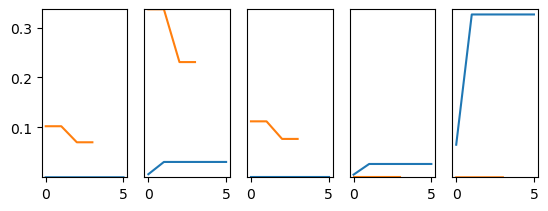

In [126]:
input_currents = params_best['I']@ points_bias
max_current = np.max(input_currents)
min_current = np.min(input_currents)
for neuron in range(H):
    plt.subplot(2,5,neuron+1)
    plt.plot(input_currents[neuron,:])
    plt.ylim([min_current, max_current])

    if neuron%5 != 0:
        plt.yticks([])

unique_x = np.unique(points_raw[0,:])
unique_y = np.unique(points_raw[1,:])
mean_values_x = np.zeros([H, len(unique_x)])
mean_values_y = np.zeros([H, len(unique_y)])
for val_ind, val in enumerate(unique_x):
    mean_values_x[:,val_ind] = np.var(input_currents[:,points_raw[0,:] == val], axis = 1)
for val_ind, val in enumerate(unique_y):
    mean_values_y[:,val_ind] = np.var(input_currents[:,points_raw[1,:] == val], axis = 1)


min_mean = np.min([np.min(mean_values_x), np.min(mean_values_y)])
max_mean = np.max([np.max(mean_values_x), np.max(mean_values_y)])

plt.figure()
for neuron in range(H):
    plt.subplot(2,5,neuron+1)
    plt.plot(mean_values_x[neuron,:])
    plt.plot(mean_values_y[neuron,:])
    plt.ylim([min_mean, max_mean])

    if neuron%5 != 0:
        plt.yticks([])


63.38515


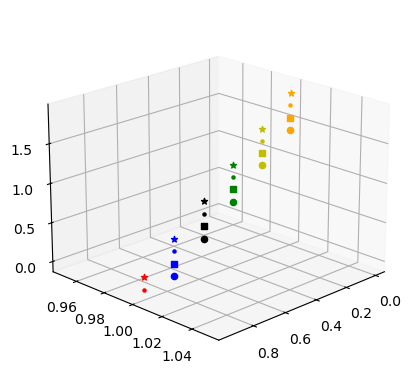

In [127]:
g_best = generate_rep(params_best['I'], points_bias)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for count in range(D):
    ax.scatter(g_best[0,count], g_best[5,count], g_best[1,count], c = colours[count], marker = markers[count])
print(min_loss)
ax.view_init(elev=20., azim=45)

33.086548


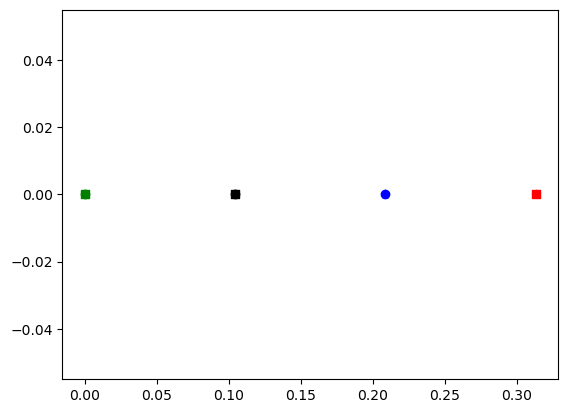

In [410]:
g_best = generate_rep(params_best['I'], points_bias)
fig = plt.figure()
for count in range(D):
    plt.scatter(g_best[0,count], g_best[5,count], c = colours[count], marker = markers[count])
print(min_loss)


In [ ]:
# Is it my weird setup?

In [295]:
mu_fit = 10000
mu_G = 1
mu_R = 1
mu_I = 1
fit_thresh = 0.01

@jit
def loss(params, inputs, outputs):
    g = generate_rep(params["I"], inputs)

    return mu_fit*jnn.relu(loss_fit(g, params['R'], outputs)-fit_thresh) + mu_G*loss_act(g) + mu_R*loss_weight_I(params["I"]) + mu_I*loss_weight_I(params['R'])
    
@jit
def update(params, inputs, outputs, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, inputs, outputs)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, value

random_seed = 4363321
learning_rate = 1e-3

re_init = 0
if re_init:
    key = random.PRNGKey(random_seed)
    I = random.normal(key, (H, 3))*0.001
    R = random.normal(key, (H+1, 2))*0.001
    optimizer = optax.adam(learning_rate)
    # Obtain the `opt_state` that contains statistics for the optimizer.
    params = {'I': I, 'R': R}
    opt_state = optimizer.init(params)
print(loss(params, points_bias, points))
min_loss = np.infty

22.177813


In [296]:
# Optimisation, run and re-run until it stops hitting new records
T = 10000000
print_iter = 100000

for t in range(T):
    params, opt_state, loss = update(params, points_bias, points, opt_state)

    if t % print_iter == 0:
        g = generate_rep(params["I"], points_bias)
        R = generate_R(g, points)

        L_f = loss_fit(g, R, points)
        L_a = loss_act(g)
        L_R = loss_weight_I(R)
        L_I = loss_weight_I(params["I"])    
        print(f"Step {t}, Loss: {loss:.5f}, Fit: {L_f:.5f}, Act: {L_a:.5f}, R: {L_R:.5f}, I: {L_I:.5f}")
        #print(f"Step {t}, Loss: {loss:.5f}")#, Fit: {L_f:.5f}, Act: {L_a:.5f}, Wei: {L_w:.5f}, R: {L_R:.5f}, Pos: {L_p:.5f}, PI: {L_PI:.5f}")

        min_this_step = 0

    if loss < min_loss:
        params_best = params
        min_loss = loss
        if min_this_step == 0:
            print(f'New min! {loss}')
            min_this_step = 1

Step 0, Loss: 22.17781, Fit: 0.04732, Act: 16.41825, R: 5.39882, I: 0.36915
New min! 22.177812576293945
Step 100000, Loss: 22.15991, Fit: 0.03257, Act: 16.38902, R: 5.36104, I: 0.36841
New min! 22.123737335205078
Step 200000, Loss: 22.09319, Fit: 0.04364, Act: 16.31204, R: 5.45103, I: 0.36738
New min! 22.08454704284668
Step 300000, Loss: 25.62997, Fit: 0.03136, Act: 16.26110, R: 5.45268, I: 0.36652
New min! 22.045791625976562
Step 400000, Loss: 22.04209, Fit: 0.01393, Act: 16.24375, R: 5.42046, I: 0.36573
New min! 22.005596160888672
Step 500000, Loss: 21.98055, Fit: 0.02097, Act: 16.15868, R: 5.45460, I: 0.36474
New min! 21.966964721679688
Step 600000, Loss: 21.93624, Fit: 0.06449, Act: 16.11080, R: 5.43724, I: 0.36387
New min! 21.930992126464844
Step 700000, Loss: 21.90115, Fit: 0.02649, Act: 16.07434, R: 5.43488, I: 0.36310
New min! 21.89288330078125
Step 800000, Loss: 21.87394, Fit: 0.01044, Act: 16.02682, R: 5.46987, I: 0.36228
New min! 21.856231689453125
Step 900000, Loss: 21.8417

Propotion of Activity Kept: 1.0


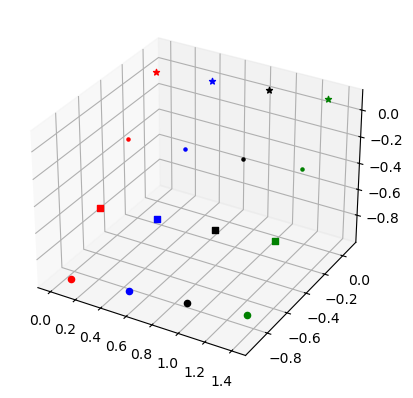

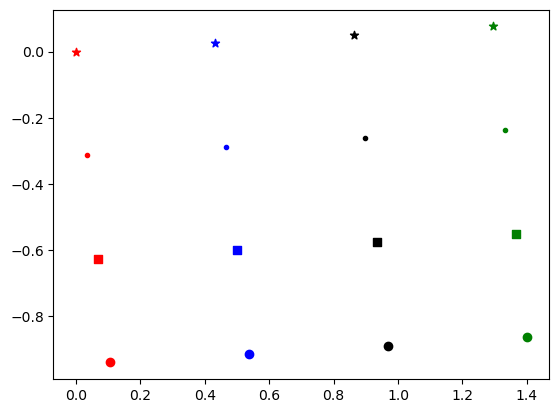

In [293]:
g_best = generate_rep(params_best['I'], points_bias)
PCs = get_2_PCs(g_best, num_eigs = 2)
proj_best = PCs.T@g_best

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for count in range(D):
    ax.scatter(proj_best[0,count], proj_best[1,count], proj_best[2,count], c = colours[count], marker = markers[count])

fig = plt.figure()
for count in range(D):
    plt.scatter(proj_best[0,count], proj_best[1,count], c = colours[count], marker = markers[count])

In [289]:
np.linalg.norm(R, axis = 0)

array([1.7561187, 2.581867 ], dtype=float32)

/var/folders/7s/qvjsjmdx0xz163b26_jzw9300000gn/T/ipykernel_94161/3636546756.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  y_max = -y_min*(1-p)/p
/var/folders/7s/qvjsjmdx0xz163b26_jzw9300000gn/T/ipykernel_94161/3636546756.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  corr[1,p_ind] = x_max*y_min*(1-p) + x_min*y_max*p


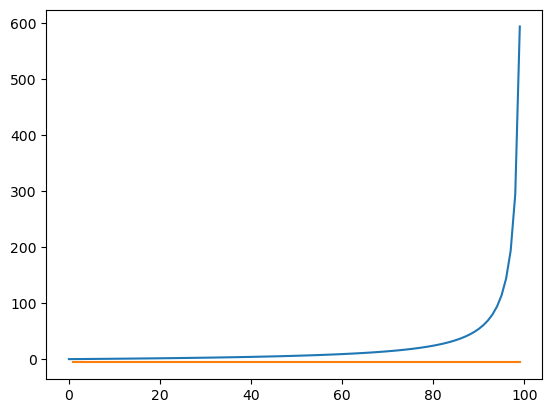

In [39]:
x_min = -2
y_min = -3
ps = np.arange(0, 1, 0.01)
corr = np.zeros([2,100])

for p_ind, p in enumerate(ps):
    y_max = -y_min*p/(1-p)
    x_max = -x_min*p/(1-p)

    corr[0,p_ind] = x_max*y_max*(1-p) + x_min*y_min*p

    y_max = -y_min*(1-p)/p
    x_max = -x_min*p/(1-p)

    corr[1,p_ind] = x_max*y_min*(1-p) + x_min*y_max*p

    
plt.plot(corr.T)

In [40]:
corr

array([[ 0.00000000e+00,  6.06060606e-02,  1.22448980e-01,
         1.85567010e-01,  2.50000000e-01,  3.15789474e-01,
         3.82978723e-01,  4.51612903e-01,  5.21739130e-01,
         5.93406593e-01,  6.66666667e-01,  7.41573034e-01,
         8.18181818e-01,  8.96551724e-01,  9.76744186e-01,
         1.05882353e+00,  1.14285714e+00,  1.22891566e+00,
         1.31707317e+00,  1.40740741e+00,  1.50000000e+00,
         1.59493671e+00,  1.69230769e+00,  1.79220779e+00,
         1.89473684e+00,  2.00000000e+00,  2.10810811e+00,
         2.21917808e+00,  2.33333333e+00,  2.45070423e+00,
         2.57142857e+00,  2.69565217e+00,  2.82352941e+00,
         2.95522388e+00,  3.09090909e+00,  3.23076923e+00,
         3.37500000e+00,  3.52380952e+00,  3.67741935e+00,
         3.83606557e+00,  4.00000000e+00,  4.16949153e+00,
         4.34482759e+00,  4.52631579e+00,  4.71428571e+00,
         4.90909091e+00,  5.11111111e+00,  5.32075472e+00,
         5.53846154e+00,  5.76470588e+00,  6.00000000e+0

In [33]:
ps

array([0])